# Import Libraries
First of all, let's import all the libraries we will need later.

In [ ]:
from google.colab import drive
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from keras.models import Model
import random as rn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import matplotlib.cm as cm
import cv2
from google.colab.patches import cv2_imshow

# Load dataset from Google Drive
The dataset is stored on Google Drive, we will unzip it locally to improve the performance

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/My Drive/CV_Birds/Dataset.zip" -d "/content"

# Set parameters

In [ ]:
DATASET_PATH = "/content/Dataset"
TRAINING_PATH = DATASET_PATH + '/train'
VALIDATION_PATH = DATASET_PATH + '/valid'
TEST_PATH = DATASET_PATH + '/test'

GLOBAL_MODELS_FOLDER_152 = "/content/drive/My Drive/CV_Birds/models/ResNet152v2"

# Default values to load the dataset
BATCH_SIZE = 128
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
SEED = 24
NUM_CLASSES = 325

# Utility functions

In [ ]:
def set_seed ():
  ''' 
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(SEED)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(SEED)
  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(SEED)

set_seed()

def get_index_by_layer_name(model, layer_name):
  '''
  get_index_by_layer_name is used to retrieve the index of a specific layer
  :param model: model to check
  :param layer_name: name of the layer we want to get the index of
  :return: the index of the layer named as defined in layer_name
  '''
  for index, layer in enumerate(model.layers):
      if layer.name == layer_name:
          return index

# Heatmaps of class activation
This technique is useful to understand which parts of a given image led a convnet to its final classification decision.

In [ ]:
def get_img_array(img_path, target_size):
  '''
  get_img_array returns the numpy array of the image
  :param img_path: path of the image
  :param target_size: size of the image (image is squared)
  :return: a numpy array
  '''
  img = keras.utils.load_img(img_path, target_size=target_size)
  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  return array

def get_last_conv_layer_index (model):
  '''
  get_last_conv_layer_index is used to retrieve the index of the last convolutional layer of the model
  :param model: model considered
  :return: the index of the last convolutional layer
  '''
  index = 0
  i = 0
  for i, layer in enumerate(model.layers):
    if len(layer.output_shape) == 4:
      index = i # each time we found a conv layer we update the index
  if index == 0: # no conv layers
    raise ValueError("Could not find convnet layer. Cannot apply GradCAM.")
  return index
  

def make_heatmap (img_array, model, last_conv_layer_index):
  '''
  make_heatmap is used to create the heatmap that shows the gradient-weighted class activation mapping
  :param img_array: a numpy array that represents the image
  :param model: model considered
  :param last_conv_layer_index: index of the last convolutional layer of the model
  :param class_index: class of the image 
  :return: the heatmap
  '''
  # We create a model that maps the input image to the activations of the last convolutional layer 
  # And a model that maps the activation value to the predictions
  intermediate_layer_model = keras.Model(inputs=model.inputs, outputs=model.layers[last_conv_layer_index + 1].input)
  classifier_model = Model([model.layers[last_conv_layer_index + 1].input], model.output)

  # We compute the gradient of the predictions with respect to the activations of the last convolutional layer
  with tf.GradientTape() as tape:
    last_conv_layer_output = intermediate_layer_model(img_array)
    predictions = classifier_model(last_conv_layer_output)
    tape.watch([last_conv_layer_output, predictions])
    top_pred_index = tf.argmax(predictions[0])
    prediction = predictions[:, top_pred_index]
    
  # gradient of the output neuron with respect to the output feature map of the last conv layer
  grads = tape.gradient(prediction, last_conv_layer_output)

  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() # evaluate the mean over the gradient tensor, for each channel separately
  weighted_last_conv_layer_output = last_conv_layer_output.numpy()[0]
  for i in range(pooled_grads.shape[-1]):
    weighted_last_conv_layer_output[:, :, i] *= pooled_grads[i] # the i-th feature map is weighted with the i-th gradient

  heatmap = np.mean(weighted_last_conv_layer_output, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  return heatmap

def compute_gradcam(img_path, heatmap, alpha=0.4):
  '''
  compute_gradcam is used to superimpose the heatmap on top of the image
  :param img_path: where is located the image
  :param heatmap: heatmap precomputed 
  :return: the superimposed image
  '''
  img = keras.preprocessing.image.load_img(img_path)
  img = keras.preprocessing.image.img_to_array(img)

  # rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)

  # Use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # Create an image with RGB colorized heatmap
  jet_heatmap = keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.utils.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * alpha + img
  superimposed_img = keras.utils.array_to_img(superimposed_img)
  return superimposed_img

def display_gradcams(model, how_many_to_skip=0, how_many_to_show=0):
  '''
  dispaly_gradcams is used to compute and plot all the gradcams requested in alphabetical order
  :param model: model to analyze
  :param how_many_to_skip: how many gradcam computation to skip
  :param how_many_to_show: how many gradcam computation to show
  '''
  n_rows = 5
  n_cols = 5
  fig = plt.figure(figsize=(10, 10))
  classes = sorted(os.listdir(TEST_PATH))
  classes=classes[how_many_to_skip:]
  classes=classes[:how_many_to_show]
  for i, c in tqdm(enumerate(classes)):
    image_name = sorted(os.listdir(f'{TEST_PATH}/{c}'))[0] # first image for each class
    img_path = TEST_PATH + f'/{c}/' + image_name
    img_array = get_img_array(img_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    heatmap = make_heatmap(img_array, model, get_last_conv_layer_index(model))
    gradcam = compute_gradcam(img_path, heatmap)
    plt.subplot(n_rows, n_cols, i+1)
    plt.title(f'{c}')
    plt.imshow(gradcam)
  
  plt.subplots_adjust(right=2, top=2)
  plt.show()

def display_gradcams_of_list_of_classes(classes, model):
  '''
  display_gradcams_of_list_of_classes is used to compute and display the gradcam of the classes required
  :param classes: classes to be considered
  :param model: model to analyze
  '''
  n_rows = 5
  n_cols = 5
  fig = plt.figure(figsize=(10, 10))
  for i, c in tqdm(enumerate(classes)):
    image_name = sorted(os.listdir(f'{TEST_PATH}/{c}'))[0] # first image for each class
    img_path = TEST_PATH + f'/{c}/' + image_name
    img_array = get_img_array(img_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    heatmap = make_heatmap(img_array, model, get_last_conv_layer_index(model))
    gradcam = compute_gradcam(img_path, heatmap)
    plt.subplot(n_rows, n_cols, i+1)
    plt.title(f'{c}')
    plt.imshow(gradcam)
  
  plt.subplots_adjust(right=2, top=2)
  plt.show()

## Feature Extraction

### ResNet50v2 extracted feature
We want to show why the simple feature extraction doesn't work in out project

In [ ]:
conv_base = keras.applications.resnet_v2.ResNet50V2(weights='imagenet', input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))

102883328/102869336 [==============================] - 2s 0us/step


##### Worst ones

0it [00:00, ?it/s]

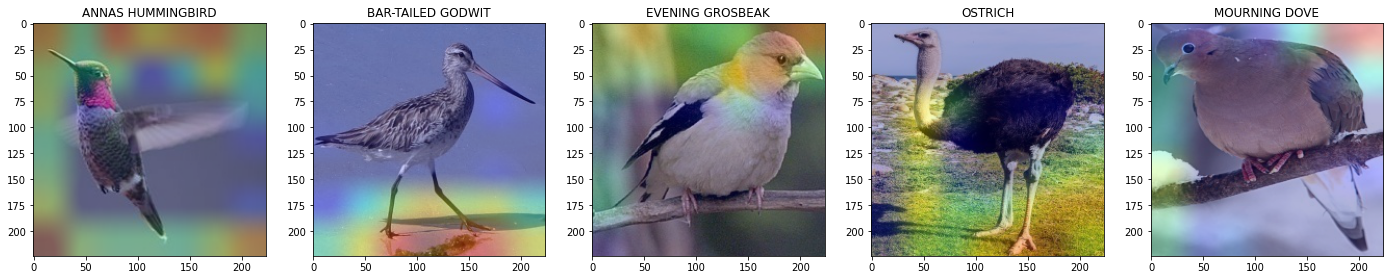

In [ ]:
display_gradcams_of_list_of_classes(["ANNAS HUMMINGBIRD", "BAR-TAILED GODWIT", "EVENING GROSBEAK", "OSTRICH", "MOURNING DOVE"], conv_base)

### One dense layer with 512 neurons and dropout of ResNet152v2
If we add the dense layer and we train it we reach good results, also without finetuning.

In [ ]:
model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER_152 + '/OneDense512_Dropout_feature_extraction.h5')

In [ ]:
display_gradcams(model, how_many_to_skip=0, how_many_to_show=25)

Output hidden; open in https://colab.research.google.com to view.

#### Worst ones

0it [00:00, ?it/s]

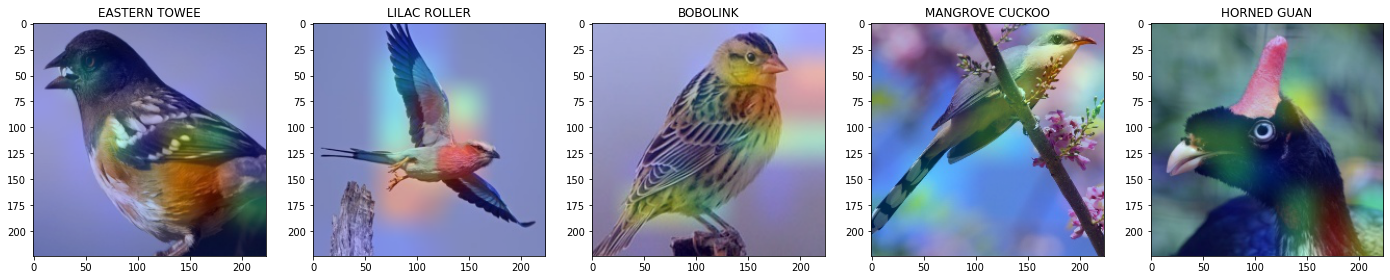

In [ ]:
display_gradcams_of_list_of_classes(["EASTERN TOWEE", "LILAC ROLLER", "BOBOLINK", "MANGROVE CUCKOO", "HORNED GUAN"], model)

#### Best ones

0it [00:00, ?it/s]

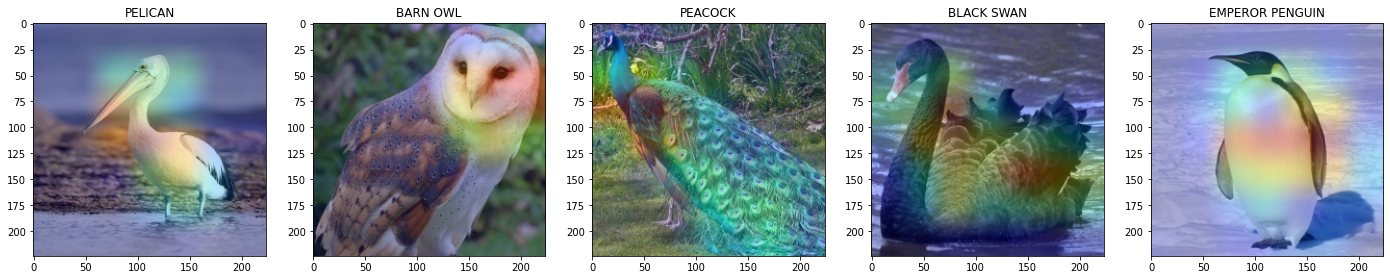

In [ ]:
display_gradcams_of_list_of_classes(["PELICAN", "BARN OWL", "PEACOCK", "BLACK SWAN", "EMPEROR PENGUIN"], model)

## Fine tuning

### One dense layer with 512 neurons and dropout of ResNet152v2

In [ ]:
model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER_152 + '/OneDense512_Dropout_fine_tuning.h5')

In [ ]:
display_gradcams(model, how_many_to_skip=0, how_many_to_show=25)

Output hidden; open in https://colab.research.google.com to view.

##### Worst ones

0it [00:00, ?it/s]

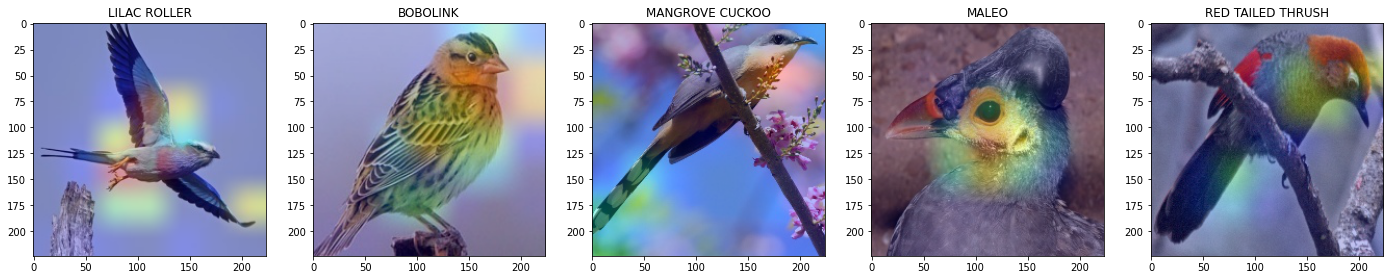

In [ ]:
display_gradcams_of_list_of_classes(["LILAC ROLLER", "BOBOLINK", "MANGROVE CUCKOO", "MALEO", "RED TAILED THRUSH"], model)

##### Best ones

0it [00:00, ?it/s]

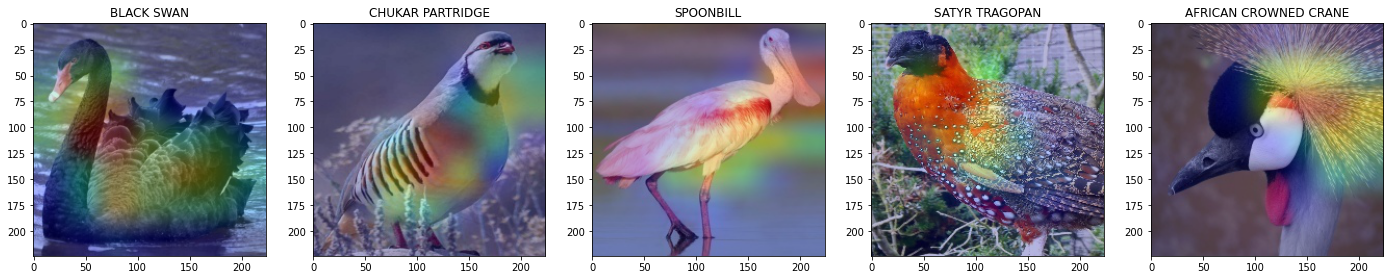

In [ ]:
display_gradcams_of_list_of_classes(["BLACK SWAN", "CHUKAR PARTRIDGE", "SPOONBILL", "SATYR TRAGOPAN", "AFRICAN CROWNED CRANE"], model)